Notes
- Need to remember how to initialize om4labs package locally
- Checks on x and y dimension naming (different names in different models)

In [94]:
import argparse
import pkg_resources as pkgr
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# from om4labs import m6plot
import palettable
import xarray as xr
import warnings

from xhistogram.xarray import histogram
import gfdl_utils as gu
import gsw

# from om4labs.om4common import horizontal_grid
# from om4labs.om4common import image_handler
# from om4labs.om4common import date_range
# from om4labs.om4common import open_intake_catalog
# from om4labs.om4parser import default_diag_parser

warnings.filterwarnings("ignore", message=".*csr_matrix.*")
warnings.filterwarnings("ignore", message=".*dates out of range.*")


def calculate(ds, bins_sigma2):
    """Calculates volumetric histogram of age and density"""
    
    # Normalize age
    agemax = ds['agessc'].max(dim=['lon','lat','z_l'])
    
    # Calculate density
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma2'].name = 'sigma2'
    
    bins_age = np.arange(0,1,0.01)
    
    hs = histogram(ds['sigma2'],
                   ds['agessc']/agemax,
                   bins=[bins_sigma2,bins_age],
                   dim=['lon','lat','z_l'],
                   weights=ds['volcello'],
                   block_size=len(ds['time']))
        
    return hs

def read(dictArgs, age_varname="agessc", volume_varname="volcello", 
         temp_varname="thetao", salt_varname="so"):
    """Read in age, volume, and T-S data"""

    infile = dictArgs["infile"]
    ds = xr.open_mfdataset(infile, combine="by_coords", use_cftime=True)
    ds = ds.chunk({'time':1})
    
    # Check that all required variables are here
    check_vars=[age_varname, volume_varname,
                temp_varname, salt_varname]
    check = all(item in ds.data_vars for item in check_vars)
    if not check:
        missing = set(check_vars)-set(ds.data_vars)
        raise RuntimeError("Necessary variable {} not present in dataset".format(missing))
        
    # DO I NEED TO IMPOSE NAMES ?
    
    # ds["areacello"] = xr.open_mfdataset(dictArgs["static"])["areacello"]
    # ds["deptho"] = xr.open_mfdataset(dictArgs["static"])["deptho"]
    # ds["geolat"] = xr.open_mfdataset(dictArgs["static"])["geolat"]
    # ds["geolon"] = xr.open_mfdataset(dictArgs["static"])["geolon"]
        
    if "bins_sigma2" in dictArgs:
        bins_args = dictArgs["bins_sigma2"]
        bins_args = tuple([float(x) for x in bins_args.split(",")])
        bins_sigma2 = np.arange(*bins_args)
    else:
        # Default bins
        bins_sigma2 = np.arange(32,38,0.05)

    return (
        ds,
        bins_sigma2
    )

def plot(hs):
    
    def calc_weightedstats_hs(hs,dim='agessc_bin'):
        """Calculate weighted mean statistics of histogram bin values
        along specifed dimension. That is, the histogram counts/sums 
        provide the weights."""

        # Expand bin values to full array
        array = hs[dim]*xr.ones_like(hs)
        # Calculate statistics
        mean = array.weighted(hs).mean(dim)
        std = array.weighted(hs).std(dim)
        # Place in a xr.Dataset
        stats = xr.Dataset()
        stats['mean'] = mean
        stats['std'] = std
        return stats

    if 'time' in list(hs.coords):
        tmp = hs.isel(time=-1)
    
    fig,ax = plt.subplots(figsize=(4,10))

    # Normalize to PDF
    tmp = tmp/tmp.sum('sigma2_bin')
    # Get weighted statistcs for this histogram
    tmpstats = calc_weightedstats_hs(tmp,dim='agessc_bin')

    # Plot
    im = ax.pcolormesh(tmp['agessc_bin'],
                       tmp['sigma2_bin'],
                       tmp,
                       shading='auto',
                       vmax=0.05,
                       cmap='viridis')
    ax.errorbar(tmpstats['mean'],tmpstats['sigma2_bin'],
                xerr=tmpstats['std'],
                linestyle='',
                ecolor='w',
                alpha=0.2,
                marker='o',
                markerfacecolor='w',
                markeredgecolor='w')
    ax.invert_yaxis()
    ax.set_xlim([0,1])
    cb = plt.colorbar(im,ax=ax,
                 fraction=0.05,
                 pad=0.02,
                 location='top'
                 )
    cb.ax.set_xlabel('FRACTION')
    ax.set_xlabel('NORMALIZED AGE')
    ax.set_ylabel('SIGMA2')
    fig.tight_layout()

    return fig


def run(dictArgs):
    """Function to call read, calc, and plot in sequence"""

    # --- the main show ---
    (
        ds,
        bins_sigma2
    ) = read(dictArgs)

    hs = calculate(ds,bins_sigma2)

    fig = plot(hs)

    filename = f"{dictArgs['outdir']}/agehist"
    # imgbufs = image_handler([fig], dictArgs, filename=filename)

    # return imgbufs

In [99]:
pp = ('/archive/oar.gfdl.cmip6/CM4/'+
          'warsaw_201710_om4_v1.0.1/CM4_piControl_C/'+
          'gfdl.ncrc4-intel16-prod-openmp/pp/ocean_annual_z_1x1deg')
pathDict = {'pp':('/archive/oar.gfdl.cmip6/CM4/'+
                  'warsaw_201710_om4_v1.0.1/CM4_piControl_C/'+
                  'gfdl.ncrc4-intel16-prod-openmp/pp'),
            'ppname':'ocean_annual_z_1x1deg',
            'out':'av',
            'local':'annual_5yr',
            'time':'06*',
            'add':'ann'
           }


infile = gu.core.get_pathspp(**pathDict)
static = gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
outdir = '.'
                  
bins_sigma2 = '36,37.51,0.01'
dictArgs = {'infile':infile,'bins_sigma2':bins_sigma2,'static':static,
            'outdir':outdir,'interactive':False,'format':'stream'}

CPU times: user 2.09 s, sys: 431 ms, total: 2.52 s
Wall time: 2.4 s


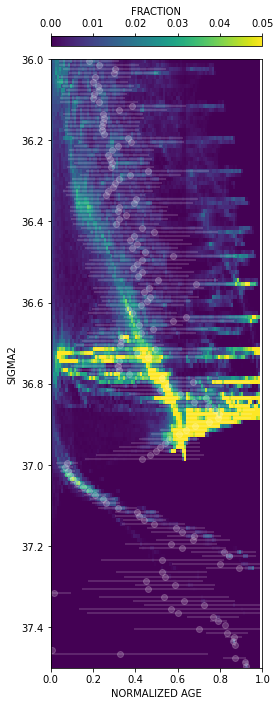

In [100]:
%time fig = run(dictArgs)